In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

## Load and inspect data

In [2]:
actors_df = pd.read_csv('data/preprocessed/lead_actors_data_on_subset_movie.csv')
print(actors_df.info())
movie_df = pd.read_csv('data/preprocessed/subset_movie_with_full_data_on_lead_actors.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145 entries, 0 to 3144
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   wikipedia_movie_id      3145 non-null   int64  
 1   freebase_movie_id       3145 non-null   object 
 2   movie_release_date      3145 non-null   object 
 3   character_name          3145 non-null   object 
 4   actor_dob               3145 non-null   object 
 5   actor_gender            3145 non-null   object 
 6   actor_height            3145 non-null   float64
 7   actor_name              3145 non-null   object 
 8   actor_age_at_release    3145 non-null   float64
 9   character_actor_map_id  3145 non-null   object 
 10  character_id            3145 non-null   object 
 11  actor_id                3145 non-null   object 
 12  actor_ethnicity_label   3145 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 319.5+ KB
None


## Filter and Clean Data

In [3]:
# Merge datasets and add adjusted box office feature
actors_df = actors_df.merge(movie_df, on='wikipedia_movie_id', how='inner')

In [4]:
# Select relevant features for clustering
features = actors_df[['actor_height', 'actor_age_at_release', 'actor_gender']].dropna()


## Standardize and one-hot encode features

In [5]:
# Normalize numeric features
numeric_features = features[['actor_height', 'actor_age_at_release']]
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(numeric_features)

In [6]:
encoded_categorical=pd.get_dummies(features['actor_gender'],prefix = 'gender')
final_features = np.hstack([scaled_numeric, encoded_categorical])


## Determine the Optimal Number of Clusters

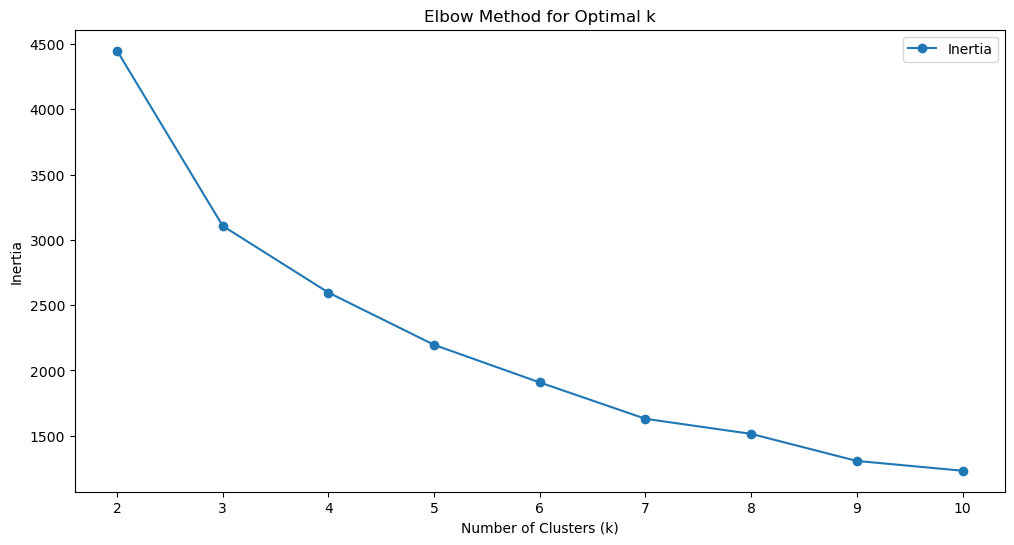

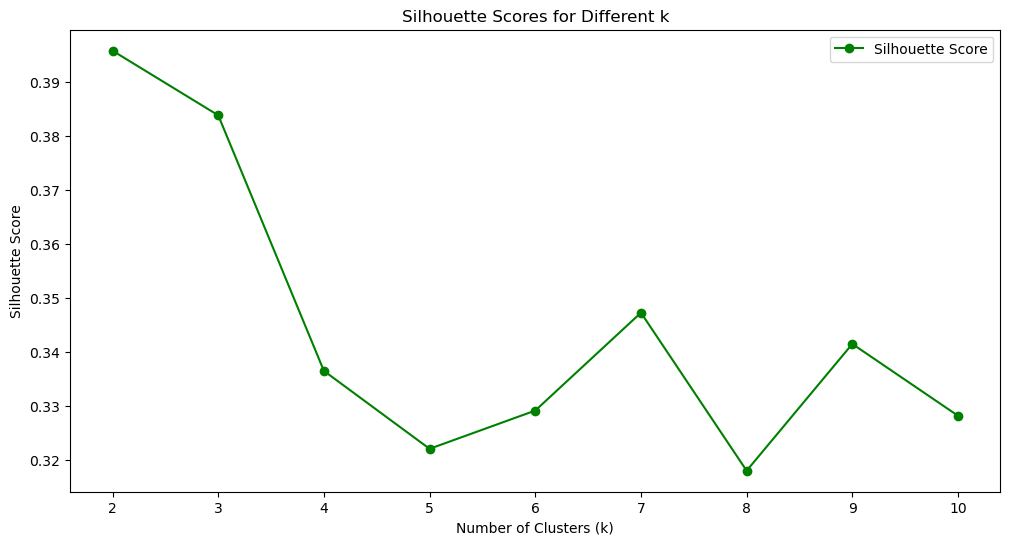

In [7]:
# Find the optimal number of clusters using the elbow method
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(12, 6))
plt.plot(k_values, inertia, marker='o', label='Inertia')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.legend()
plt.show()

# Plot silhouette scores
plt.figure(figsize=(12, 6))
plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.legend()
plt.show()

The first plot shows an "elbow" at K=3. The second plot would suggest K=2 as the silhouette score is the highest there. The score is however also high at K=3 so we will go with 3 clusters

## Apply K-Means Clustering an visualize using PCA

In [8]:
# Dimensionality reduction using PCA
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(final_features)

In [9]:
# Choose optimal number of clusters (based on above plots)
optimal_k = 3  # Replace with your optimal choice based on the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(pca_features)

In [10]:
# Add cluster labels back to the original dataset
features['Cluster'] = cluster_labels
actors_df['Cluster'] = cluster_labels


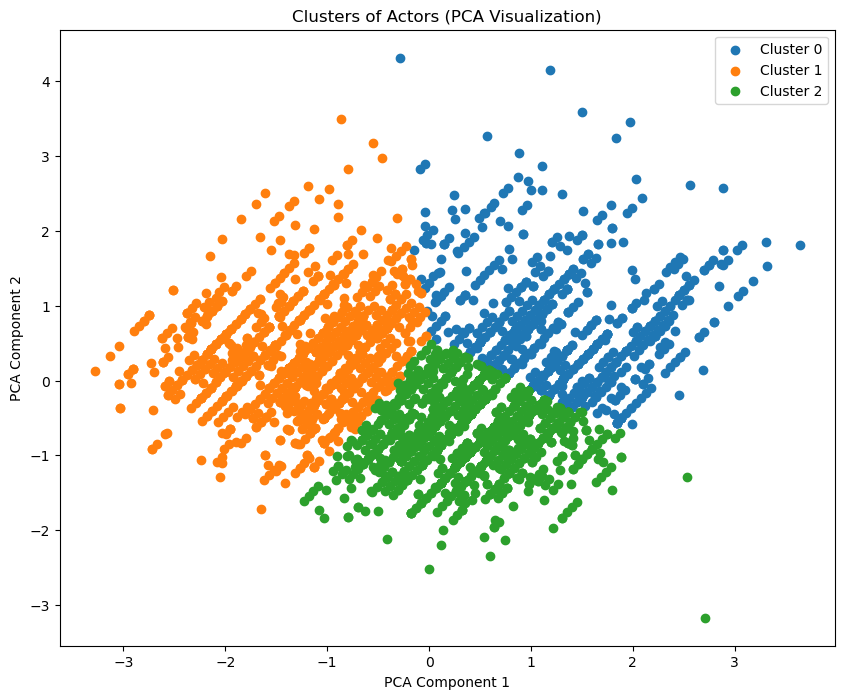

In [11]:
# Visualize clusters with PCA components
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = pca_features[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title('Clusters of Actors (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

## Analyze

In [12]:
# Compute cluster characteristics
for cluster in range(optimal_k):
    cluster_data = features[features['Cluster'] == cluster]
    print(f"Cluster {cluster} Characteristics:")
    print(cluster_data[['actor_height', 'actor_age_at_release']].describe())
    print(f"Gender Distribution:\n{cluster_data['actor_gender'].value_counts()}")

Cluster 0 Characteristics:
       actor_height  actor_age_at_release
count    739.000000            739.000000
mean       1.812724             53.158322
std        0.071987              8.392512
min        1.524000             43.000000
25%        1.770000             46.000000
50%        1.830000             51.000000
75%        1.880000             58.000000
max        1.960000             86.000000
Gender Distribution:
actor_gender
M    700
F     39
Name: count, dtype: int64
Cluster 1 Characteristics:
       actor_height  actor_age_at_release
count   1151.000000           1151.000000
mean       1.669026             31.064292
std        0.057578              8.682779
min        1.520000              8.000000
25%        1.630000             25.000000
50%        1.680000             30.000000
75%        1.710000             37.000000
max        1.780000             65.000000
Gender Distribution:
actor_gender
F    965
M    186
Name: count, dtype: int64
Cluster 2 Characteristics:
       

### Cluster Characteristics

#### Cluster 0 Characteristics:
- **Actors in this cluster are predominantly male, with only 39 female actors and 700 males.**
- **Average actor height is high (1.812 meters) with relatively low variation, indicating taller actors dominate this cluster.**
- **The average age at release is 53.16 years, suggesting that this group primarily consists of older, experienced actors.**
- **This cluster includes the oldest actors, with a maximum age of 86 years.**

#### Cluster 1 Characteristics:
- **This cluster is dominated by female actors, with 965 females and 186 males.**
- **Average height is the shortest across all clusters (1.669 meters), with a narrow range.**
- **The average age at release is 31.06 years, indicating this cluster primarily represents younger actors.**
- **The youngest actors (minimum age: 8 years) belong to this cluster**

#### Cluster 2 Characteristics:
- **This cluster is heavily male-dominated, with 1,215 male and 40 female actors.**
- **Average height is comparable to Cluster 0 (1.815 meters), but the cluster includes the tallest actors (maximum height: 2.16 meters).**
- **The average age at release is 32.16 years, similar to Cluster 1.**
- **This group seems to represent younger, taller male actors.**


In [13]:
# Analyze revenue by cluster
cluster_revenue = actors_df.groupby('Cluster')['adjusted_box_office'].describe()
print("Adjusted Box Office Revenue by Cluster:")
print(cluster_revenue)

Adjusted Box Office Revenue by Cluster:
          count          mean           std           min           25%  \
Cluster                                                                   
0         739.0  1.381211e+08  2.083500e+08  19015.612192  2.061486e+07   
1        1151.0  1.124169e+08  2.142947e+08     44.928288  1.350671e+07   
2        1255.0  1.179789e+08  1.958646e+08      2.608370  1.608417e+07   

                  50%           75%           max  
Cluster                                            
0        5.751993e+07  1.843686e+08  2.693334e+09  
1        4.214289e+07  1.243818e+08  4.022758e+09  
2        4.810376e+07  1.291529e+08  2.147346e+09  


### Adjusted Box Office Revenue by Cluster

#### Cluster 0:
- **This cluster has the highest average revenue at 138 million dollars, with a wide standard deviation of 208 million dollars.**
- **Revenue distribution in this cluster ranges from as low as 19,015 dollars to a maximum of 2.69 billion dollars.**
- **The median revenue (57.5 million dollars) and the 75th percentile (184.4 million dollars) highlight that a subset of actors in this cluster achieved exceptional box office success.**

#### Cluster 1:
- **The lowest average revenue (112.4 million dollars) is observed in this cluster, with the highest standard deviation of 214.3 million dollars.**
- **Revenue ranges from a minimum of 44 dollars to an impressive maximum of 4.02 billion dollars, showing a diverse spectrum of box office performance.**
- **The median revenue (42.1 million dollars) indicates that most actors in this cluster have relatively modest box office outcomes, but a few significantly outperform.**

#### Cluster 2:
- **The average revenue for this cluster is 117.9 million dollars, slightly higher than Cluster 1, with a lower standard deviation (195.9 million dollars).**
- **Revenue spans from a minimum of 2.60 dollars to a maximum of 2.15 billion dollars.**
- **The median revenue (48.1 million dollars) and 75th percentile (129.1 million dollars) suggest that actors in this cluster typically achieve moderate success, with fewer extreme outliers compared to Cluster 1.**

#### Overall Insights:
- Clusters 0 and 2 seem to contain actors with consistent or moderately high success, whereas Cluster 1 shows the widest range, encompassing actors from struggling to blockbuster-level performance.


In [14]:
# Additional statistical analysis on gender and revenue
from scipy.stats import ttest_ind

male_revenue = actors_df[actors_df['actor_gender'] == 'M']['adjusted_box_office']
female_revenue = actors_df[actors_df['actor_gender'] == 'F']['adjusted_box_office']

# Perform t-test
stat, p_value = ttest_ind(male_revenue, female_revenue, nan_policy='omit')
print(f"T-test for Revenue by Gender: t-statistic = {stat:.3f}, p-value = {p_value:.3f}")

if p_value <= 0.05:
    print("There is a statistically significant difference in revenue by gender.")
else:
    print("No statistically significant difference in revenue by gender.")

T-test for Revenue by Gender: t-statistic = 2.807, p-value = 0.005
There is a statistically significant difference in revenue by gender.


### Statistical Analysis of Revenue by Gender

- **T-test Results:**
  - T-statistic: 2.807
  - P-value: 0.005

#### Interpretation:
- The p-value (0.005) is equal to the commonly used significance threshold of 0.05, indicating that the observed difference in adjusted box office revenue between male and female actors is statistically significant.
- **This suggests that gender plays a role in the revenue generation of actors, with male actors, on average, generating different revenue compared to female actors.**
- Further analysis might be required to understand the factors contributing to this difference, such as roles, movie genres, and industry dynamics.
